# **COMPETENCIA KAGGLE**

**IMPORTO LIBRERIAS**

In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import os
from datetime import datetime
pd.set_option('display.max_columns', None)


In [2]:


# Definir la ruta base
ruta_base = r'C:/Users/jnnov/OneDrive/Documentos/AUSTRAL/MATERIAS/2_CUAT_2DO/LABO 3\Datasets Competencia/1ERA COMPETENCIA'

# Leer los archivos
sell_in_path = os.path.join(ruta_base, 'sell-in.txt')
tb_productos_path = os.path.join(ruta_base, 'tb_productos.txt')
tb_stocks_path = os.path.join(ruta_base, 'tb_stocks.txt')
tb_productos_descripcion_path = os.path.join(ruta_base, 'tb_productos_descripcion.txt')

ruta_archivo = ruta_base + '/productos_predecir.xlsx'
productos_predecir = pd.read_excel(ruta_archivo)



sell_in = pd.read_csv(sell_in_path, sep='\t')  # Cambia 'sep' si el separador es diferente
tb_productos = pd.read_csv(tb_productos_path, sep='\t')
tb_productos_descripcion = pd.read_csv(tb_productos_descripcion_path, sep='\t')

tb_stocks = pd.read_csv(tb_stocks_path, sep='\t')

In [3]:
productos_predecir.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [4]:
sell_in.head(5)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [5]:
tb_productos.head(5)

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [6]:
tb_productos_descripcion.head()

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa
4,FOODS,ADEREZOS,Chimichurri,NATURA,350,20797,Chimichurri


#### **sell_in**

In [4]:
sell_in.groupby(['periodo', 'customer_id'])['tn'].sum().reset_index()

,periodo,customer_id,tn
0,201701,10001,2543.89944
1,201701,10002,3143.64478
2,201701,10003,2425.98913
3,201701,10004,1738.91838
4,201701,10005,1058.82526
...,...,...,...
16487,201912,10582,0.78468
16488,201912,10584,0.08577
16489,201912,10599,0.21840
16490,201912,10606,0.51523


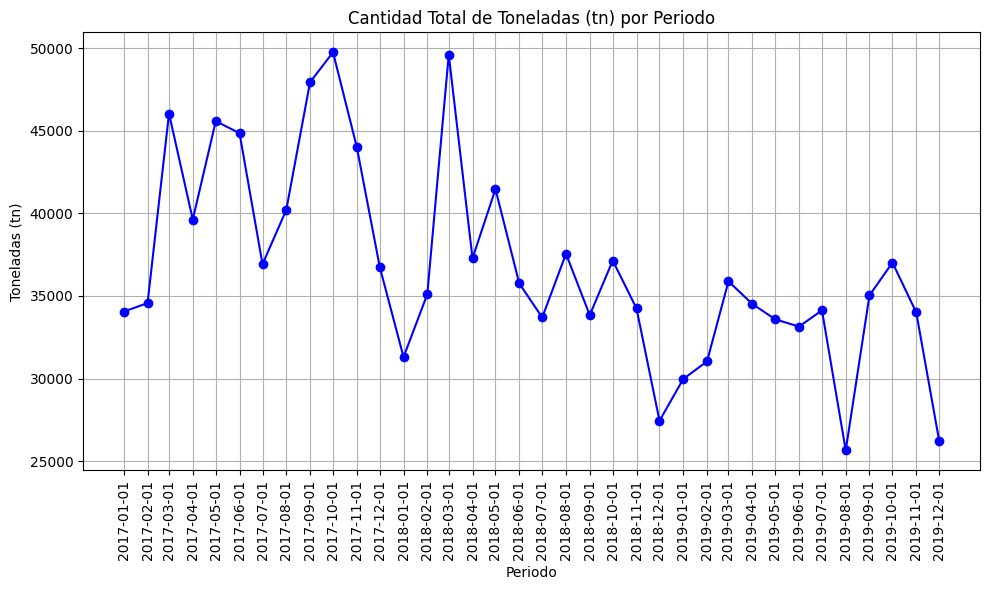

In [8]:

# Cargar el DataFrame desde el archivo

# Calcular la cantidad total de toneladas (tn) por periodo
total_tn_por_periodo = sell_in.groupby('periodo')['tn'].sum().reset_index()

# Convertir la columna 'periodo' a tipo datetime para el gráfico de línea
total_tn_por_periodo['periodo'] = pd.to_datetime(total_tn_por_periodo['periodo'], format='%Y%m')

# Crear el gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(total_tn_por_periodo['periodo'], total_tn_por_periodo['tn'], marker='o', linestyle='-', color='b')
plt.title('Cantidad Total de Toneladas (tn) por Periodo')
plt.xlabel('Periodo')
plt.ylabel('Toneladas (tn)')
plt.grid(True)
#plt.xticks(rotation=45)
#plt.tight_layout()

# Mostrar el gráfico
#plt.show()
# Ajustar las etiquetas del eje x para que estén en formato vertical
plt.xticks(rotation=90)

# Asegurar que todas las etiquetas se muestren
plt.gca().set_xticks(total_tn_por_periodo['periodo'])

# Ajustar el diseño para evitar recortes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [9]:
sell_in.shape

(2945818, 7)

In [6]:
sell_in['diferencia_tn'] = sell_in['cust_request_tn'] - sell_in['tn']


In [11]:
sell_in.head(15)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,diferencia_tn
0,201701,10234,20524,0,2,0.05300,0.05300,0.0
1,201701,10032,20524,0,1,0.13628,0.13628,0.0
2,201701,10217,20524,0,1,0.03028,0.03028,0.0
3,201701,10125,20524,0,1,0.02271,0.02271,0.0
4,201701,10012,20524,0,11,1.54452,1.54452,0.0
5,201701,10080,20524,0,1,0.01514,0.01514,0.0
6,201701,10015,20524,0,4,0.10600,0.10600,0.0
7,201701,10062,20524,0,1,0.18928,0.18928,0.0
8,201701,10159,20524,0,3,0.02271,0.02271,0.0
9,201701,10183,20524,0,1,0.01514,0.01514,0.0


In [12]:
sell_in.describe()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,diferencia_tn
count,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06
mean,2.018017e+05,1.017148e+04,2.042787e+04,1.155163e-02,2.148753e+00,4.593203e-01,4.497863e-01,9.534001e-03
std,8.142115e+01,1.421467e+02,3.124612e+02,1.068559e-01,3.571552e+00,3.222836e+00,3.108355e+00,3.760922e-01
min,2.017010e+05,1.000100e+04,2.000100e+04,0.000000e+00,1.000000e+00,1.000000e-04,1.000000e-04,-1.519277e+01
25%,2.017090e+05,1.005300e+04,2.016100e+04,0.000000e+00,1.000000e+00,1.029000e-02,1.027000e-02,0.000000e+00
50%,2.018050e+05,1.013300e+04,2.036600e+04,0.000000e+00,1.000000e+00,3.931000e-02,3.931000e-02,0.000000e+00
75%,2.019030e+05,1.026700e+04,2.065400e+04,0.000000e+00,2.000000e+00,1.572500e-01,1.572500e-01,0.000000e+00
max,2.019120e+05,1.063700e+04,2.129900e+04,1.000000e+00,9.200000e+01,5.515614e+02,5.478785e+02,1.405797e+02


In [7]:
sell_in_group = sell_in.groupby(['periodo', 'product_id', "customer_id"]).agg({
    'cust_request_tn': 'sum',
    'tn': 'sum',
    'diferencia_tn': 'sum'
}).reset_index()

In [49]:
sell_in_group.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn
0,201701,20001,10001,99.43861,99.43861,0.00000
1,201701,20001,10002,38.68301,35.72806,2.95495
2,201701,20001,10003,143.49426,143.49426,0.00000
3,201701,20001,10004,184.72927,184.72927,0.00000
4,201701,20001,10005,19.08407,19.08407,0.00000


In [15]:

#sell_in_group2 = pd.merge(sell_in_group, tb_stocks[['periodo', 'product_id', 'stock_final']], on=['periodo', 'product_id'], how='left')



In [16]:
#sell_in_group2.tail()

#### **tb_productos**

In [17]:
tb_productos.shape

(1262, 6)

In [18]:
tb_productos['cat2'].nunique()


15

In [19]:
tb_productos.groupby(['cat2', 'cat3']).size().nunique()


28

#### **tb_productos_descripcion**

In [20]:
tb_productos_descripcion.head()

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa
4,FOODS,ADEREZOS,Chimichurri,NATURA,350,20797,Chimichurri


In [21]:
tb_productos_descripcion.drop_duplicates(subset=['cat1', 'cat2', 'cat3', 'brand', 'descripcion']).shape[0]



837

In [22]:
tb_productos_descripcion.shape

(1251, 7)

In [23]:
tb_productos_descripcion['cat2'].nunique()


15

#### **tb_stocks**


In [24]:
tb_stocks.head(10)

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595
5,201810,20828,10.51140
6,201810,20941,1.49926
7,201810,20803,0.86351
8,201810,20781,3.71171
9,201810,20638,36.99762


In [25]:
tb_stocks.shape

(13691, 3)

#### **productos_predecir**

In [26]:
productos_predecir.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [27]:
productos_predecir.count()

product_id    780
dtype: int64

#### **Combinacion de sell in y de productos_descripcion**

In [8]:
sell_in_productos = pd.merge(sell_in_group, tb_productos_descripcion,  on='product_id', how='left')

In [9]:
sell_in_productos.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion
0,201701,20001,10001,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
1,201701,20001,10002,38.68301,35.72806,2.95495,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
2,201701,20001,10003,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
3,201701,20001,10004,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
4,201701,20001,10005,19.08407,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma


In [52]:
sell_in.shape

(2945818, 8)

In [53]:
sell_in_group.shape

(2945818, 6)

In [54]:
sell_in_productos.shape

(2945818, 12)

In [10]:
sell_in_productos.isna().sum()

periodo               0
product_id            0
customer_id           0
cust_request_tn       0
tn                    0
diferencia_tn         0
cat1               7448
cat2               7448
cat3               7448
brand              7448
sku_size           7448
descripcion        7448
dtype: int64

In [11]:
sell_in_productos[sell_in_productos['cat1'].isna()].tail()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion
2805571,201910,20918,10001,16.08149,16.08149,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2813145,201910,21169,10004,9.00356,9.00356,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2814147,201910,21228,10162,0.00452,0.00452,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2814148,201910,21228,10233,0.06028,0.06028,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2887530,201911,21228,10174,0.05425,0.05425,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
sell_in_productos.describe()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,sku_size
count,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.938370e+06
mean,2.018017e+05,2.042787e+04,1.017148e+04,4.593203e-01,4.497863e-01,9.534001e-03,4.468480e+02
std,8.142115e+01,3.124612e+02,1.421467e+02,3.222836e+00,3.108355e+00,3.760922e-01,7.456050e+02
min,2.017010e+05,2.000100e+04,1.000100e+04,1.000000e-04,1.000000e-04,-1.519277e+01,1.000000e+00
25%,2.017090e+05,2.016100e+04,1.005300e+04,1.029000e-02,1.027000e-02,0.000000e+00,9.000000e+01
50%,2.018050e+05,2.036600e+04,1.013300e+04,3.931000e-02,3.931000e-02,0.000000e+00,2.400000e+02
75%,2.019030e+05,2.065400e+04,1.026700e+04,1.572500e-01,1.572500e-01,0.000000e+00,4.500000e+02
max,2.019120e+05,2.129900e+04,1.063700e+04,5.515614e+02,5.478785e+02,1.405797e+02,1.000000e+04


**PRODUCTOS A PREDECIR EN DICIEMBRE 2019**

In [12]:
product_ids_201912 = sell_in_productos[sell_in_productos['periodo'] == 201912]['product_id'].unique()
product_ids_201912

array([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009,
       20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017, 20018,
       20019, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20027,
       20028, 20029, 20030, 20031, 20032, 20033, 20035, 20037, 20038,
       20039, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048,
       20049, 20050, 20051, 20052, 20053, 20054, 20055, 20056, 20057,
       20058, 20059, 20061, 20062, 20063, 20065, 20066, 20067, 20068,
       20069, 20070, 20071, 20072, 20073, 20074, 20075, 20076, 20077,
       20078, 20079, 20080, 20081, 20082, 20084, 20085, 20086, 20087,
       20088, 20089, 20090, 20091, 20092, 20093, 20094, 20095, 20096,
       20097, 20099, 20100, 20101, 20102, 20103, 20105, 20106, 20107,
       20108, 20109, 20111, 20112, 20113, 20114, 20115, 20116, 20117,
       20118, 20119, 20120, 20121, 20122, 20123, 20124, 20125, 20126,
       20127, 20128, 20129, 20130, 20132, 20133, 20134, 20135, 20136,
       20137, 20138,

In [13]:
len(product_ids_201912)

927

**PRODUCTOS A PREDECIR SI LO HAGO CON 201912**

In [13]:
sell_in_productos_201912 = sell_in_productos[sell_in_productos['product_id'].isin(product_ids_201912)]


In [15]:
sell_in_productos_201912.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion
0,201701,20001,10001,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
1,201701,20001,10002,38.68301,35.72806,2.95495,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
2,201701,20001,10003,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
3,201701,20001,10004,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
4,201701,20001,10005,19.08407,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma


Lo filtro por los 780 productos a predecir:

#### **Filtro por los productos a predecir para 202002**

In [36]:
sell_in_productos.describe()

,periodo,product_id,cust_request_tn,tn,diferencia_tn,sku_size
count,31243.000000,31243.000000,31243.000000,31243.000000,31243.000000,31014.000000
mean,201810.415773,20532.624236,43.308070,42.409134,0.898935,477.782711
std,81.679451,345.827573,113.558671,109.789323,5.373795,884.966316
min,201701.000000,20001.000000,0.000640,0.000440,-14.346800,1.000000
25%,201710.000000,20237.000000,2.309595,2.300625,0.000000,90.000000
50%,201807.000000,20491.000000,9.827020,9.781470,0.000000,250.000000
75%,201904.000000,20807.000000,30.197970,29.956800,0.003390,475.000000
max,201912.000000,21299.000000,2423.708810,2295.198320,190.704550,10000.000000


#### **Variables de Prophet**

In [17]:
prophet_data = "prophet_fe_data.csv"
df_prophet = pd.read_csv(prophet_data, decimal='.', delimiter=',', encoding='utf-8')

In [18]:
columnas= ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

for columna in columnas:
    df_prophet[columna] = df_prophet[columna].apply(lambda x: max(x, 0))

In [19]:
df_prophet['periodo'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')
df_prophet['periodo'] = df_prophet['periodo'].dt.strftime('%Y%m').astype(int)

In [20]:
columnas_seleccionadas= ['periodo', 'product_id', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

df_prophet = df_prophet[columnas_seleccionadas]

In [21]:
df_prophet.head()

,periodo,product_id,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper
0,201701,20001,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,201702,20001,1262.235256,552.200472,1185.622572,1262.235256,1262.235256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,201703,20001,1271.645129,1169.577591,1836.598993,1271.645129,1271.645129,241.601638,241.601638,241.601638,241.601638,241.601638,241.601638
3,201704,20001,1280.751458,743.639264,1375.402442,1280.751458,1280.751458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,201705,20001,1290.161331,1094.231747,1724.686243,1290.161331,1290.161331,118.402960,118.402960,118.402960,118.402960,118.402960,118.402960


In [22]:
sell_in_productos_fe  = sell_in_productos_201912.merge(df_prophet, on=['product_id', 'periodo'], how='left')
sell_in_productos_fe.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper
0,201701,20001,10001,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0
1,201701,20001,10002,38.68301,35.72806,2.95495,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0
2,201701,20001,10003,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0
3,201701,20001,10004,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0
4,201701,20001,10005,19.08407,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
sell_in_productos_fe.dtypes

periodo                   int64
product_id                int64
customer_id               int64
cust_request_tn         float64
tn                      float64
diferencia_tn           float64
cat1                     object
cat2                     object
cat3                     object
brand                    object
sku_size                float64
descripcion              object
trend                   float64
yhat_lower              float64
yhat_upper              float64
trend_lower             float64
trend_upper             float64
additive_terms          float64
additive_terms_lower    float64
additive_terms_upper    float64
yearly                  float64
yearly_lower            float64
yearly_upper            float64
dtype: object

In [51]:
#sell_in_productos_fe['periodo'] = pd.to_datetime(sell_in_productos_fe['periodo'], format='%Y%m')


#### **Target**

In [24]:
### Agrego el target
sell_in_productos_fe['target'] = sell_in_productos_fe.groupby('product_id')['tn'].shift(-2)

In [25]:
sell_in_productos_fe.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target
0,201701,20001,10001,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,143.49426
1,201701,20001,10002,38.68301,35.72806,2.95495,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,184.72927
2,201701,20001,10003,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,19.08407
3,201701,20001,10004,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,43.83179
4,201701,20001,10005,19.08407,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,65.12087


#### Estandarizo cada serie

In [26]:

# Copiar el DataFrame original
sell_in_trans = sell_in_productos_fe.copy()

# Seleccionar las columnas numéricas
columnas_numericas = sell_in_productos_fe.select_dtypes(include=['float64', 'int64']).columns
columnas_numericas = columnas_numericas.drop(['periodo', 'customer_id', 'product_id', 'target'])

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar las columnas numéricas en los datos de entrenamiento
sell_in_trans[columnas_numericas] = scaler.fit_transform(sell_in_trans[columnas_numericas])




In [27]:
columnas_numericas

Index(['cust_request_tn', 'tn', 'diferencia_tn', 'sku_size', 'trend',
       'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper'],
      dtype='object')

In [28]:
sell_in_trans.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target
0,201701,20001,10001,29.169208,30.263303,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,143.49426
1,201701,20001,10002,11.259533,10.780176,7.375108,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,184.72927
2,201701,20001,10003,42.156033,43.735825,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,19.08407
3,201701,20001,10004,54.311384,56.345777,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,43.83179
4,201701,20001,10005,5.482112,5.690329,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,65.12087


In [29]:
sell_in_productos_fe.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target
0,201701,20001,10001,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,143.49426
1,201701,20001,10002,38.68301,35.72806,2.95495,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,184.72927
2,201701,20001,10003,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,19.08407
3,201701,20001,10004,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,43.83179
4,201701,20001,10005,19.08407,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,0.0,0.0,0.0,0.0,0.0,0.0,65.12087


In [30]:
df = sell_in_trans.copy()
df = df.sort_values(by=['product_id', 'periodo'])

# Lags (meses)
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for lag in lags:
    df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)

# Delta lags (meses)
for lag in lags:    
    df[f'delta_lag_{lag}'] = df[f'lag_{lag}'] - df[f'lag_{lag}'].shift(1)
    
# Medias moviles
for window in lags:
    df[f'moving_avg_{window}'] = df.groupby(['product_id'])['tn'].transform(lambda x: x.shift().rolling(window=window, min_periods=window).mean())
    
# Ratios
df['ratio_3'] = df['tn'] / df['moving_avg_3']
df['ratio_6'] = df['tn'] / df['moving_avg_6']

for i in range(2, 13):
    df[f'max_{i}_months'] = (df['tn'] == df['tn'].rolling(window=i, min_periods=i).max()).astype(int)

In [31]:
import calendar


In [32]:
# Quarter
def fiscal_quarter(month):
    if month in [7, 8, 9]:
        return 1
    elif month in [10, 11, 12]:
        return 2
    elif month in [1, 2, 3]:
        return 3
    else:
        return 4

# Temporales

# Asegurarse de que 'periodo' esté en formato de cadena
df['periodo'] = df['periodo'].astype(str)

# Extraer el año de los primeros 4 caracteres y convertirlo a entero
df['Year'] = df['periodo'].str[:4].astype(int)
df['Month'] = df['periodo'].str[4:6].astype(int)

# Aplicar la función fiscal_quarter para obtener el trimestre fiscal
df['Q'] = df['Month'].apply(fiscal_quarter)

# Calcular el número de días en cada mes
df['Days_Month'] = df.apply(lambda row: calendar.monthrange(row['Year'], row['Month'])[1], axis=1)

# Convertir 'periodo' a un objeto datetime
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

# Calcular las características de continuidad
df['month_sin'] = np.sin(2 * np.pi * df['periodo'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['periodo'].dt.month / 12)

In [87]:
df.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,delta_lag_12,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,moving_avg_7,moving_avg_8,moving_avg_9,moving_avg_10,moving_avg_11,moving_avg_12,ratio_3,ratio_6,max_2_months,max_3_months,max_4_months,max_5_months,max_6_months,max_7_months,max_8_months,max_9_months,max_10_months,max_11_months,max_12_months
0,201701,20001,10001,29.169208,30.263303,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,143.49426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,201701,20001,10002,11.259533,10.780176,7.375108,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,184.72927,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
2,201701,20001,10003,42.156033,43.735825,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,19.08407,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.780176,20.521740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0
3,201701,20001,10004,54.311384,56.345777,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,43.83179,43.735825,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.955649,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.735825,27.258001,28.259768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.993851,NaN,1,1,1,0,0,0,0,0,0,0,0
4,201701,20001,10005,5.482112,5.690329,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,65.12087,56.345777,43.735825,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.609951,32.955649,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.345777,50.040801,36.953926,35.28127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153984,NaN,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df_20001 = df.query("product_id == 20001")
df_20001.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,cat1,cat2,cat3,brand,sku_size,descripcion,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,delta_lag_12,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,moving_avg_7,moving_avg_8,moving_avg_9,moving_avg_10,moving_avg_11,moving_avg_12,ratio_3,ratio_6,max_2_months,max_3_months,max_4_months,max_5_months,max_6_months,max_7_months,max_8_months,max_9_months,max_10_months,max_11_months,max_12_months,Year,Month,Q,Days_Month,month_sin,month_cos
0,2017-01-01,20001,10001,29.169208,30.263303,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,143.49426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,2017,1,3,31,0.5,0.866025
1,2017-01-01,20001,10002,11.259533,10.780176,7.375108,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,184.72927,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,2017,1,3,31,0.5,0.866025
2,2017-01-01,20001,10003,42.156033,43.735825,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,19.08407,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.780176,20.521740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,2017,1,3,31,0.5,0.866025
3,2017-01-01,20001,10004,54.311384,56.345777,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,43.83179,43.735825,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.955649,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.735825,27.258001,28.259768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.993851,NaN,1,1,1,0,0,0,0,0,0,0,0,2017,1,3,31,0.5,0.866025
4,2017-01-01,20001,10005,5.482112,5.690329,-0.026129,HC,ROPA LAVADO,Liquido,ARIEL,3.486107,genoma,7.875836,5.096282,6.491397,7.875836,7.875836,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,-0.202595,65.12087,56.345777,43.735825,10.780176,30.263303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.609951,32.955649,-19.483127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.345777,50.040801,36.953926,35.28127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153984,NaN,0,0,0,0,0,0,0,0,0,0,0,2017,1,3,31,0.5,0.866025


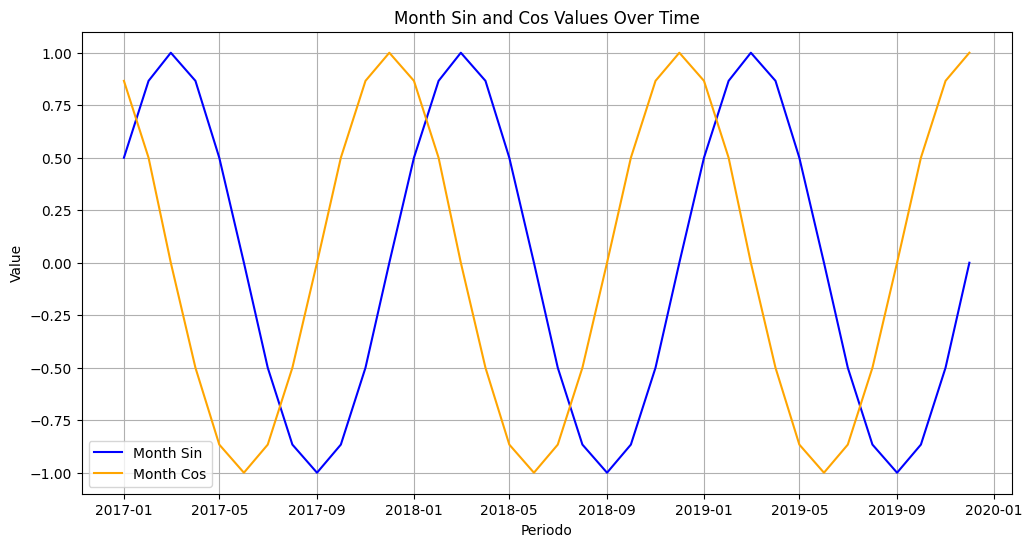

In [29]:
# Plotear las columnas 'periodo', 'month_sin' y 'month_cos'
plt.figure(figsize=(12, 6))
plt.plot(df_20001['periodo'], df_20001['month_sin'], label='Month Sin', color='blue')
plt.plot(df_20001['periodo'], df_20001['month_cos'], label='Month Cos', color='orange')

plt.xlabel('Periodo')
plt.ylabel('Value')
plt.title('Month Sin and Cos Values Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
df.isna().sum()

periodo            0
product_id         0
customer_id        0
cust_request_tn    0
tn                 0
                  ..
Month              0
Q                  0
Days_Month         0
month_sin          0
month_cos          0
Length: 79, dtype: int64

In [65]:
# Definir el nombre del archivo de salida
#nombre_archivo = 'suma_tn_por_product_id.xlsx'

# Guardar el DataFrame en Excel
#ruta_salida = 'C:/Users/jnnov/OneDrive/Documentos/AUSTRAL/MATERIAS/2_CUAT_2DO/LABO 3/Datasets Competencia/1ERA COMPETENCIA/' + nombre_archivo
#suma_tn_por_product_id.to_excel(ruta_salida, index=False)

#### **One hot**

In [34]:
df = pd.get_dummies(df, columns=['cat1', 'cat2', 'cat3', 'brand', 'descripcion'])


In [35]:
df.head()

,periodo,product_id,customer_id,cust_request_tn,tn,diferencia_tn,sku_size,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,delta_lag_12,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,moving_avg_7,moving_avg_8,moving_avg_9,moving_avg_10,moving_avg_11,moving_avg_12,ratio_3,ratio_6,max_2_months,max_3_months,max_4_months,max_5_months,max_6_months,max_7_months,max_8_months,max_9_months,max_10_months,max_11_months,max_12_months,Year,Month,Q,Days_Month,month_sin,month_cos,cat1_FOODS,cat1_HC,cat1_PC,cat1_REF,cat2_ADEREZOS,cat2_CABELLO,cat2_DENTAL,cat2_DEOS,cat2_HOGAR,cat2_OTROS,cat2_PIEL1,cat2_PIEL2,cat2_PROFESIONAL,cat2_ROPA ACONDICIONADOR,cat2_ROPA LAVADO,cat2_ROPA MANCHAS,cat2_SOPAS Y CALDOS,cat2_TE,cat2_VAJILLA,cat3_ACONDICIONADOR,cat3_Acond Bebe,cat3_Acond Mujer,cat3_Aero,cat3_Aji Picante,cat3_Almidon,cat3_Antigrasa,cat3_Azul,cat3_BARRAS,cat3_Baking Bags,cat3_Barbacoa,cat3_Barra,cat3_Baño,cat3_Bizcochuelo,cat3_CREMA,cat3_CUIDADO ESPECIAL,cat3_Caldo Cubo,cat3_Caldos Granulados,cat3_Cara,cat3_Cepilllo,cat3_Chimichurri,cat3_Concentrado,cat3_Cremoso,cat3_Cristalino,cat3_Cuerpo,cat3_DETOX,cat3_Desmaquillante,cat3_Diluido,cat3_Dishes,cat3_Especial,cat3_Esponja,cat3_Frutas,cat3_Galletitas,cat3_Gel,cat3_Gel Ducha,cat3_Hierbas,cat3_INDUSTRIAL,cat3_JABON LIQUIDO,cat3_Jabon Antibacterial,cat3_Jabon Barba,cat3_Jabon Barra,cat3_Jabon Bebe,cat3_Jabon Glicerina,cat3_Jabon Hotel,cat3_Jabon Regular,cat3_Ketchup,cat3_LAVANDINA EN GEL,cat3_LIQUIDOS,cat3_LV ROPA LIQUIDO,cat3_LV ROPA POLVO,cat3_Ladrillo,cat3_Limpieza,cat3_Limpieza Cara,cat3_Liquido,cat3_Mayonesa,cat3_Mostaza,cat3_NUTRICION,cat3_Niños,cat3_NoAero,cat3_Opaco,cat3_PACKS,cat3_PISOS,cat3_POST WASH,cat3_Pastas,cat3_Paño,cat3_Pies Aero,cat3_Pies NoAero,cat3_Pies Talco,cat3_Polvo,cat3_Pure de Papas,cat3_Pure de Tomate,cat3_PurePapas,cat3_Repelente,cat3_RollOn,cat3_SHAMPOO,cat3_SUAVIZANTE,cat3_Salsa Golf,cat3_Salsas,cat3_Salsas Dry,cat3_Salsas Wet,cat3_Sazonadores,cat3_Shampoo Bebe,cat3_Sopas,cat3_Stick,cat3_Styling,cat3_TOILETTE,cat3_Talco,cat3_Toallitas Bebe,cat3_Tratamiento Fem,cat3_Tratamiento Masc,cat3_Verde,cat3_Vidrios,brand_ARIEL,brand_AYUDIN,brand_CAPILATIS,brand_COLBERT,brand_COLGATE,brand_DEOS1,brand_DEOS2,brand_DEOS3,brand_DOWNY,brand_ESPADOL,brand_FRANCIA,brand_GOMINA,brand_HARINAMA,brand_INDUSTRIAL,brand_Importado,brand_JABON1,brand_LANCOME,brand_LIMPIEX,brand_MAGGI,brand_MAGGI2,brand_MAJESTA,brand_MAYOS3,brand_MOSTAZA1,brand_MUSCULO,brand_NATURA,brand_NIVEA,brand_OFF,brand_ROPEX1,brand_ROPEX2,brand_SALSATI,brand_SHAMPOO1,brand_SHAMPOO2,brand_SHAMPOO3,brand_SKIN1,brand_TWININGS,brand_VICHY,brand_VIVERE,descripcion_AA,descripcion_Abrillantador,descripcion_Accion Profunda,descripcion_Acondicinador Bebe,descripcion_Acondicionador 1,descripcion_Acondicionador 10,descripcion_Acondicionador 11,descripcion_Acondicionador 13,descripcion_Acondicionador 3,descripcion_Acondicionador 4,descripcion_Acondicionador 5,descripcion_Activación,descripcion_Active,descripcion_Active Gel Aloe Vera,descripcion_Active Gel Antibacterial,descripcion_Active Gel Citrica,descripcion_Active Gel Limon,descripcion_Active Gel Limon Verde,descripcion_Active Gel Pepino,descripcion_Almidon,descripcion_Antartida,descripcion_Anti Smog,descripcion_Anti Stress,descripcion_Antibacterial,descripcion_Antibacterial Aloe,descripcion_Antibacterial Menta,descripcion_Antigenos 2 en 1 doypack,descripcion_Antigenos 2 en 1 gatillo,descripcion_Aroma 1,descripcion_Aroma 10,descripcion_Aroma 11,descripcion_Aroma 12,descripcion_Aroma 13,descripcion_Aroma 14,descripcion_Aroma 15,descripcion_Aroma 18,descripcion_Aroma 19,descripcion_Aroma 2,descripcion_Aroma 21,descripcion_Aroma 3,descripcion_Aroma 5,

In [93]:
df.dtypes

periodo                        int64
product_id                     int64
customer_id                    int64
cust_request_tn              float64
tn                           float64
                              ...   
descripcion_ropa negra          bool
descripcion_rulos vitales       bool
descripcion_sport               bool
descripcion_sport extremo       bool
descripcion_trigo               bool
Length: 718, dtype: object

#### **XGBoost con semillerio**

In [40]:
import warnings
warnings.filterwarnings("ignore")

----
-----
----
---
--


**PARA VARIOS CUSTOMER_ID**

In [40]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import pandas as pd

# Supongamos que el DataFrame 'df' ya está definido
# df = pd.read_csv('tus_datos.csv')

# Lista de customer_ids
customer_ids_top_50 = [10001,
10002,
10003,
10004,
10005,
10006,
10007,
10008,
10009,
10010,
10011,
10012,
10013,
10014,
10015,
10016,
10017,
10018,
10019,
10020,
10021,
10022,
10023,
10024,
10025,
10026,
10027,
10030,
10031,
10032
]  # Reemplaza con tu lista real

df_customer = df

# Convertir 'periodo' a datetime si no lo está
df_customer['periodo'] = pd.to_datetime(df_customer['periodo'], format='%Y%m')

# Ordenar los datos por 'periodo'
df_customer = df_customer.sort_values('periodo')

# Definir las fechas de corte como objetos datetime
train_cutoff = pd.to_datetime('2019-06-01')
val_cutoff = pd.to_datetime('2019-08-01')
test_cutoff = pd.to_datetime('2019-10-01')

# Filtrar datos para entrenamiento y validación
df_train = df_customer[df_customer['periodo'] <= train_cutoff]
df_val = df_customer[(df_customer['periodo'] > train_cutoff) & (df_customer['periodo'] <= val_cutoff)]
df_test = df_customer[df_customer['periodo'] == test_cutoff]



# Separar características (X) y variable objetivo (y)
X_train = df_train.drop(['periodo', 'target'], axis=1)
y_train = df_train['target']
X_val = df_val.drop(['periodo', 'target'], axis=1)
y_val = df_val['target']
X_test = df_test.drop(['periodo','target'], axis=1)
y_test = df_test['target']

# DataFrame para almacenar todas las predicciones
all_predictions = pd.DataFrame()

# Definir función de objetivo para la optimización de hiperparámetros
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    # Entrenar y validar con cada una de las semillas
    seeds = [111111,222222,333333,444444,555555,666666,777777,888888,999999,121212,131313,141414,151515,161616,171717,181818,191919,202020,212121,222222,232323,242424,252525,262626]
    rmses = []
    for seed in seeds:
        param['random_state'] = seed
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=12, verbose=False)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

# Crear el estudio de optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar y predecir con 5 semillas diferentes
seeds = [1111, 2222, 3333, 4444, 5555]

for customer_id in customer_ids_top_50:
    df_customer = df[df['customer_id'] == customer_id]
    
    # Convertir 'periodo' a datetime si no lo está ya
    df_customer['periodo'] = pd.to_datetime(df_customer['periodo'], format='%Y%m')

    # Ordenar los datos por 'periodo'
    df_customer = df_customer.sort_values('periodo')

    # Definir las fechas de corte
    train_cutoff = pd.to_datetime('2019-06-01')
    val_cutoff = pd.to_datetime('2019-08-01')
    test_cutoff = pd.to_datetime('2019-10-01')

    # Filtrar datos para entrenamiento, validación y prueba
    df_train = df_customer[df_customer['periodo'] <= train_cutoff]
    df_val = df_customer[(df_customer['periodo'] > train_cutoff) & (df_customer['periodo'] <= val_cutoff)]
    df_test = df_customer[df_customer['periodo'] == test_cutoff]

    # Separar características (X) y variable objetivo (y)
    X_train = df_train.drop(['periodo', 'target'], axis=1)
    y_train = df_train['target']
    X_val = df_val.drop(['periodo', 'target'], axis=1)
    y_val = df_val['target']
    X_test = df_test.drop(['periodo', 'target'], axis=1)
    y_test = df_test['target']
    
    predictions = pd.DataFrame()
    for seed in seeds:
        model = xgb.XGBRegressor(random_state=seed, **best_params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=12, verbose=False)
        y_pred = model.predict(X_test)
        predictions[f'Prediction_seed_{seed}'] = y_pred

    predictions['product_id'] = df_test['product_id'].values
    predictions['customer_id'] = customer_id

    all_predictions = pd.concat([all_predictions, predictions], ignore_index=True)

# Mostrar el DataFrame final con todas las predicciones
print(all_predictions)


[I 2024-07-11 18:32:08,873] A new study created in memory with name: no-name-5a69c6da-9c3b-4887-b0a7-d8c5c5a2f35a
[W 2024-07-11 18:33:12,999] Trial 0 failed with parameters: {'learning_rate': 0.1500249238776008, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9878111320579077, 'colsample_bytree': 0.7774070945460612, 'n_estimators': 140} because of the following error: MemoryError((502, 2081645), dtype('O')).
Traceback (most recent call last):
  File "c:\Users\jnnov\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\jnnov\AppData\Local\Temp\ipykernel_25912\3660096557.py", line 93, in objective
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=12, verbose=False)
  File "c:\Users\jnnov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
      

MemoryError: Unable to allocate 7.79 GiB for an array with shape (502, 2081645) and data type object

In [52]:
all_predictions_csv = all_predictions.groupby(['product_id']).agg({'Prediction_seed_0':"sum",'Prediction_seed_1':"sum",'Prediction_seed_2':"sum",'Prediction_seed_3':"sum",'Prediction_seed_4':"sum", })

,Prediction_seed_0,Prediction_seed_1,Prediction_seed_2,Prediction_seed_3,Prediction_seed_4
product_id,,,,,
20001,507.808228,528.433105,484.542664,512.830505,532.481628
20002,466.439270,308.895630,379.954163,411.094513,458.622070
20003,195.010132,212.657761,273.316925,165.679428,207.122284
20004,100.321404,96.496338,117.135300,91.063393,83.981812
20005,158.432816,118.439919,176.522858,186.077789,167.467712
...,...,...,...,...,...
21227,0.091519,0.115647,0.095844,0.095584,0.120331
21255,0.673615,0.596964,0.576216,0.656407,0.589939
21257,0.673615,0.596964,0.576216,0.656407,0.589939


In [53]:

all_predictions[all_predictions['product_id']==20001]

,Prediction_seed_0,Prediction_seed_1,Prediction_seed_2,Prediction_seed_3,Prediction_seed_4,product_id,customer_id
395,103.672203,140.044189,77.301559,97.674126,114.938057,20001,10001
766,245.735016,226.577179,220.321732,271.839386,232.788818,20001,10002
1803,65.002884,42.266937,81.398178,63.177811,71.585648,20001,10004
2052,78.442871,107.907631,86.261459,66.041245,108.256546,20001,10005
2709,14.955233,11.637153,19.259727,14.097905,4.912539,20001,10003


In [59]:
df201912 = sell_in_productos_fe[(sell_in_productos_fe['periodo'] == 201912) & (sell_in_productos_fe['customer_id'].isin([10005]))][['product_id', 'tn']]
df201912

,product_id,tn
2454990,20001,19.60368
2455166,20002,20.25584
2455264,20003,21.47418
2455425,20004,11.38738
2455583,20005,40.76145
...,...,...
2512357,21207,0.00586
2512506,21220,0.02162
2512546,21224,0.00253
2512665,21234,0.02162


In [ ]:
nombre_archivo = 'all_predictions_TOPCLIENTES.csv'

# Guardar el DataFrame en Excel
ruta_salida = 'C:/Users/jnnov/OneDrive/Documentos/AUSTRAL/MATERIAS/2_CUAT_2DO/LABO 3/Datasets Competencia/1ERA COMPETENCIA/Predicciones/' + nombre_archivo
all_predictions.to_csv(ruta_salida, index=False)